# Converting Images mode to RGB to perform transfer learning using a Torchvision Image Classification model.


This notebook contains the code to download the yoga pose image classification dataset from **kaggle** and convert its images mode to 3-channel RGB mode to comply with torchvision image classification models [input image expectation](https://pytorch.org/vision/0.11/models.html). The choosen methods for converting the image mode requires Pillow 9.2.0 and is explained in 2.2.4. bellow.

The steps bellow include: downloading the dataset from kaggle using the kaggle API, extracting the dataset (unzip), exploring the data, defining the convertion methods, converting the mode of a sample of images to RGB mode, visualizing the output of the convertion, converting the full dataset (convert all the images to RGB mode), and finally compressing the output data as a zip file to be uploaded to kaggle.

The original dataset can be downloaded from kaggle: https://www.kaggle.com/datasets/shrutisaxena/yoga-pose-image-classification-dataset (shrutisaxena/yoga-pose-image-classification-dataset)

The transformed dataset (output of the code in this notebook) have been uploaded to kaggle and can be downloaded from the following link: https://www.kaggle.com/datasets/franciscadossantos/rgb-only-yoga-pose-dataset (franciscadossantos/rgb-only-yoga-pose-dataset)

The dataset contains 107 classes of yoga pose. The model will be deployed in AWS using the PyTorch ML framework and Sagemaker Python SDK. The final aim is to use these RGB images to finetune a VGG16 image classification model. 


## <a name="0">Notebook content:</a>
1. <a href="#1">Notebook setup</a>
2. <a href="#2">Dataset</a><br>
    2.1. <a href="#2.1">kaggle setup</a><br>
    2.2. <a href="#2.2">ETL</a><br>
    2.2.1. <a href="#2.2.1">Download the dataset and extract the data</a><br>
    2.2.2. <a href="#2.2.2">Explore the data</a><br>
    2.2.3. <a href="#2.2.3">Sample some images for visualization and testing image mode convertion</a><br>
    2.2.4. <a href="#2.2.4">Define function for converting images mode to RGB mode</a><br>
    2.2.5. <a href="#2.2.5">Preprocess the full dataset</a><br>
    2.2.6. <a href="#2.2.6">Compress output data</a><br>
3. <a href="#3">Clean up</a><br>


## 1. <a name="1">Notebook setup</a>
(<a href="#0">Go to top</a>)

In [1]:
import PIL

In [2]:
!pip show Pillow

Name: Pillow
Version: 9.2.0
Summary: Python Imaging Library (Fork)
Home-page: https://python-pillow.org
Author: Alex Clark (PIL Fork Author)
Author-email: aclark@python-pillow.org
License: HPND
Location: /home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages
Requires: 
Required-by: bokeh, imageio, matplotlib, scikit-image


In [3]:
## RUN THIS CELL ONLY IF NEEDED: i.e. if Pillow version showed above is < 9.2.0

!pip install Pillow==9.2.0

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 85.0 MB/s eta 0:00:00:00:01
  Attempting uninstall: Pillow
    Found existing installation: Pillow 9.0.1
    Uninstalling Pillow-9.0.1:
      Successfully uninstalled Pillow-9.0.1
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import PIL
from PIL import Image

import requests
import shutil

## 2. <a name="2">Dataset</a>
(<a href="#0">Go to top</a>)

The dataset used is composed of a total of 5994 images of yoga poses. It contains 107 classes of yoga poses, such as 'adho mukha svanasana', chakravakasana, savasana, etc.
The dataset is available on kaggle and can be downloaded via kaggle CLI from `shrutisaxena/yoga-pose-image-classification-dataset`

**Support material:**

1. kaggle. [Yoga Pose Image classification dataset](https://www.kaggle.com/datasets/shrutisaxena/yoga-pose-image-classification-dataset?select=dataset)
2. GitHub. [Kaggle API](https://github.com/Kaggle/kaggle-api)
3. stackoverflow. [Download Kaggle Dataset by using Python](https://stackoverflow.com/questions/49386920/download-kaggle-dataset-by-using-python)
4. GitHub. [split-folders](https://github.com/jfilter/split-folders)







### 2.1. <a name="2.1">kaggle setup</a>

**Note:** first of all download `kaggle.json` from kaggle website and upload it to local directory

In [6]:
# pip install kaggle CLI
!pip install -q kaggle

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [8]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle

kaggle.json


In [9]:
!chmod 600 ~/.kaggle/kaggle.json  # ensure that other users do not have read access to your credentials

### 2.2. <a name="2.2">ETL</a>
(<a href="#0">Go to top</a>)

#### 2.2.1. <a name="2.2.1">Download the dataset and extract the data</a>

In [10]:
# get a list of poptential datasets
!kaggle datasets list -s yoga

ref                                                           title                                                 size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------------  --------------------------------------------------  ------  -------------------  -------------  ---------  ---------------  
niharika41298/yoga-poses-dataset                              Yoga Poses Dataset                                   288MB  2020-10-14 09:18:41           3152         82  0.75             
ujjwalchowdhury/yoga-pose-classification                      Yoga Pose Classification                              15MB  2022-06-05 14:46:16            342         44  0.875            
shrutisaxena/yoga-pose-image-classification-dataset           Yoga Pose Image classification dataset              1004MB  2021-04-03 14:37:48           2366         82  0.875            
tr1gg3rtrash/yoga-posture-dataset                             Yog

In [11]:
%%time

#download the dataset of interest (using kaggle CLI)
!kaggle datasets download -d shrutisaxena/yoga-pose-image-classification-dataset

100%|██████████████████████████████████████| 0.98G/0.98G [00:09<00:00, 65.8MB/s]
100%|███████████████████████████████████████| 0.98G/0.98G [00:09<00:00, 112MB/s]
CPU times: user 184 ms, sys: 57.3 ms, total: 241 ms
Wall time: 10.4 s


In [14]:
# check if the data was downloaded
!ls ./

fp_submission_script-0922.ipynb  kaggle.json
fp_submission_script.ipynb	 lost+found
hpo.py				 yoga-pose-image-classification-dataset.zip


In [15]:
%%time

# extract / unzip data with {shutil}
shutil.unpack_archive('./yoga-pose-image-classification-dataset.zip', './yoga_data')

"""
# OR
# unzip data using aws CLI
!unzip -d yoga_data yoga-pose-image-classification-dataset.zip
"""

CPU times: user 6.93 s, sys: 1.12 s, total: 8.04 s
Wall time: 16 s


'\n# OR\n# unzip data using aws CLI\n!unzip -d yoga_data yoga-pose-image-classification-dataset.zip\n'

#### 2.2.2. <a name="2.2.2">Explore the data</a>

In [16]:
# take a sneaky peek at the data structure
#!ls ./yoga_data
!ls ./yoga_data/dataset

adho mukha svanasana	     padmasana
adho mukha vriksasana	     parighasana
agnistambhasana		     paripurna navasana
ananda balasana		     parivrtta janu sirsasana
anantasana		     parivrtta parsvakonasana
anjaneyasana		     parivrtta trikonasana
ardha bhekasana		     parsva bakasana
ardha chandrasana	     parsvottanasana
ardha matsyendrasana	     pasasana
ardha pincha mayurasana      paschimottanasana
ardha uttanasana	     phalakasana
ashtanga namaskara	     pincha mayurasana
astavakrasana		     prasarita padottanasana
baddha konasana		     purvottanasana
bakasana		     salabhasana
balasana		     salamba bhujangasana
bhairavasana		     salamba sarvangasana
bharadvajasana i	     salamba sirsasana
bhekasana		     savasana
bhujangasana		     setu bandha sarvangasana
bhujapidasana		     simhasana
bitilasana		     sukhasana
camatkarasana		     supta baddha konasana
chakravakasana		     supta matsyendrasana
chaturanga dandasana	     supta padangusthasana
dandasana		     supta virasana
dhanur

In [17]:
!ls ./yoga_data/dataset/'adho mukha svanasana'

10. screen-shot-2017-09-15-at-17.00.06-1024x585.png
1. 1.png
11. yoga_anatomy_using_muscle_awareness_to_lower_your_heels_in_downward_facing_dog_pose.png
12. 66a62b8c606fd88e0401b5af0a7cbca7.png
12. downward-facing-dog-pose.png
13. downward-facing-dog-800x490.png
14. downward-dog-pose-as-done-by-a-dog.png
14. untitled_design_33.png
1. 5-benefits-of-downward-facing-dog-pose.png
16. one-leg-downward-facing-dog-yoga-pose.png
17. screen_shot_2014-03-20_at_2.05.15_pm.png
18. screenshot_20180504-085613-450x800.png
19. 1-adho-mukha-svanasana.png
21. adho-mukha-svanasana.png
22. photo-17-05-2015-18-28-30.png
23. george7.png
24. dsc_1007-resized-600.jpg
25. 11.png
28. screen-shot-2017-10-30-at-2.24.06-pm.png
29. adho-mukha-svanasana.png
2. screen-shot-2017-09-15-at-17.00.06-1024x585.png
32. 1473984207.png
32. down_dog_orthocarolina_winston.png
33. screenshot_2015-02-10-12-04-46.png
34. adho-mukha-svanasana.png
35. 068155f5a8d0310c34a6ed06cb089294.png
36. downward-facing-dog-800x490.png
39. scree

In [4]:
# create a dictionary/list of classes (107 classes) that can be used later when selecting image for quering the model

# get the list of all directories within the dataset directory
data_path = "./yoga_data/dataset"
cls_list = os.listdir(data_path)
cls_list.sort()

cls_dict = {}
for i, term in enumerate(cls_list, 1):
    cls_dict[i] = term

print(f"Number of Classes: {len(cls_list)}")

Number of Classes: 107


In [7]:
# List the classes (yoga poses)
cls_dict

{1: 'adho mukha svanasana',
 2: 'adho mukha vriksasana',
 3: 'agnistambhasana',
 4: 'ananda balasana',
 5: 'anantasana',
 6: 'anjaneyasana',
 7: 'ardha bhekasana',
 8: 'ardha chandrasana',
 9: 'ardha matsyendrasana',
 10: 'ardha pincha mayurasana',
 11: 'ardha uttanasana',
 12: 'ashtanga namaskara',
 13: 'astavakrasana',
 14: 'baddha konasana',
 15: 'bakasana',
 16: 'balasana',
 17: 'bhairavasana',
 18: 'bharadvajasana i',
 19: 'bhekasana',
 20: 'bhujangasana',
 21: 'bhujapidasana',
 22: 'bitilasana',
 23: 'camatkarasana',
 24: 'chakravakasana',
 25: 'chaturanga dandasana',
 26: 'dandasana',
 27: 'dhanurasana',
 28: 'durvasasana',
 29: 'dwi pada viparita dandasana',
 30: 'eka pada koundinyanasana i',
 31: 'eka pada koundinyanasana ii',
 32: 'eka pada rajakapotasana',
 33: 'eka pada rajakapotasana ii',
 34: 'ganda bherundasana',
 35: 'garbha pindasana',
 36: 'garudasana',
 37: 'gomukhasana',
 38: 'halasana',
 39: 'hanumanasana',
 40: 'janu sirsasana',
 41: 'kapotasana',
 42: 'krounchasa

In [20]:
#count the number of images in the dataset

dir = data_path
sum = 0

for i, cls in enumerate(cls_list, 1):
  path = os.path.join(dir, cls)
  for (r, d, f) in os.walk(path):
    #print(i, ': ', len(f))
    sum += len(f)
print("Total number of images in the data set: ", sum)

Total number of images in the data set:  5994


In [21]:
## verify file extensions GIF, JPEG, PNG, etc
## and file format

def fileeimg(root):

    j = 0
    g = 0
    p = 0
    temp_ext = []
    temp_fmt = []
    temp_mde = []

    for (r, d, f) in os.walk(root, topdown=True):
        for file in f:
            path = os.path.join(r, file)
            ext = path.rpartition('.')[2]

            if not(ext in temp_ext):
                temp_ext.append(ext)

            img = Image.open(path, mode = 'r')
            mde = img.mode
            fmt = img.format

            if not(mde in temp_mde):
                temp_mde.append(mde)

            if not(fmt in temp_fmt):
                temp_fmt.append(fmt)

            img.close()

    return(temp_ext, temp_fmt, temp_mde)


root = data_path
t = fileeimg(root)

print(f"{len(t[0])} file extensions found: ")
print(t[0])
print('\n')
print(f"{len(t[1])} file formats found: ")
print(t[1])
print('\n')
print(f"{len(t[2])} image modes found: ")
print(t[2])

5 file extensions found: 
['png', 'jpeg', 'jpg', 'jpe', 'gif']


3 file formats found: 
['PNG', 'JPEG', 'GIF']


5 image modes found: 
['RGB', 'RGBA', 'P', 'L', 'LA']


In [22]:
# count the number of images in each mode

root = data_path

mde_dict = {}
for i in range(0, len(temp_mde)):
    mde_dict[temp_mde[i]] = 0

for (r, d, f) in os.walk(root, topdown=True):
    for file in f:
        path = os.path.join(r, file)
        img = Image.open(path, mode = 'r')
        mde_dict[img.mode] += 1 
        img.close()

        if path.rpartition('/')[2] == "43. chair+pose.jpg":
            print(path)

print(mde_dict)

./yoga_data/dataset/utkatasana/43. chair+pose.jpg
{'RGB': 5627, 'RGBA': 341, 'P': 19, 'L': 3, 'LA': 4}


#### 2.2.3. <a name="2.2.3">Sample some images for visualization and testing image mode convertion</a>

In [23]:
# select some images for data exploration

sample_list = [
    # images in 'P' mode
    "./yoga_data/dataset/dandasana/5. dandasana-seated-staff-pose.png", # P
    "./yoga_data/dataset/virabhadrasana i/File62.gif", # P
    "./yoga_data/dataset/virabhadrasana ii/File36.gif", # P
    "./yoga_data/dataset/tadasana/47. mountain-pose-women-silhouette.png", # P
    "./yoga_data/dataset/balasana/31. childspose2.png", # P
    "./yoga_data/dataset/adho mukha svanasana/3. downward-facing-dog-pose-567x567.png", # P
    # images in 'L' mode
    "./yoga_data/dataset/baddha konasana/81. baddha-konasana-1024x1024.png", # L
    "./yoga_data/dataset/astavakrasana/321.jpeg", # L
    "./yoga_data/dataset/padmasana/7. isolated-silhouette-woman-meditation-lotus-450w-71699359.jpg", # L
    # images in 'LA' mode
    "./yoga_data/dataset/tadasana/32. 300px-tadasana.png", # LA
    "./yoga_data/dataset/tadasana/51. 300px-viparita_namaskar_tadasana.png", # LA
    "./yoga_data/dataset/utkatasana/35. 200px-utkatasana.png", # LA
    "./yoga_data/dataset/adho mukha svanasana/50. blog-14-size.png", # LA
    # some images in 'RGBA' mode
    "./yoga_data/dataset/setu bandha sarvangasana/File34.png", #RGBA
    ## images in 'RGBA' mode and file extension .jpg
    "./yoga_data/dataset/padmasana/39. main-qimg-6af98ebfd563e35051a076689525784b.jpg", #RGBA + .jpg
    "./yoga_data/dataset/padmasana/46. main-qimg-44e71ec1e2e5f3062e2760538138e986.jpg", #RGBA + .jpg
    "./yoga_data/dataset/utkatasana/24. chairpose2.jpg", #RGBA + .jpg
    "./yoga_data/dataset/utkatasana/43. chair+pose.jpg", #RGBA + .jpg
    # an image in 'RGB' mode with a file extension typo (.jpe insted of .jpg)
    "./yoga_data/dataset/ashtanga namaskara/10. ashtanga-namaskara.jpe" #RGB
]


In [24]:
## print images mode

for path in sample_list:

    f_img = Image.open(path, mode = 'r')

    h,*c = f_img.getbands() #bands: 'R' 'G' 'B' 'A' 'P' 'L' ecc

    if len(c) == 0:
        print(f"{h} , {c}\t|\t{path}")
    elif len(c) == 1:
        print(f"{h} , {c}\t|\t{path}")
    elif len(c) == 2:
        print(f"{h} , {c}\t|\t{path}")
    else:
        print(f"{h} , {c}\t|\t{path}")

P , []	|	./yoga_data/dataset/dandasana/5. dandasana-seated-staff-pose.png
P , []	|	./yoga_data/dataset/virabhadrasana i/File62.gif
P , []	|	./yoga_data/dataset/virabhadrasana ii/File36.gif
P , []	|	./yoga_data/dataset/tadasana/47. mountain-pose-women-silhouette.png
P , []	|	./yoga_data/dataset/balasana/31. childspose2.png
P , []	|	./yoga_data/dataset/adho mukha svanasana/3. downward-facing-dog-pose-567x567.png
L , []	|	./yoga_data/dataset/baddha konasana/81. baddha-konasana-1024x1024.png
L , []	|	./yoga_data/dataset/astavakrasana/321.jpeg
L , []	|	./yoga_data/dataset/padmasana/7. isolated-silhouette-woman-meditation-lotus-450w-71699359.jpg
L , ['A']	|	./yoga_data/dataset/tadasana/32. 300px-tadasana.png
L , ['A']	|	./yoga_data/dataset/tadasana/51. 300px-viparita_namaskar_tadasana.png
L , ['A']	|	./yoga_data/dataset/utkatasana/35. 200px-utkatasana.png
L , ['A']	|	./yoga_data/dataset/adho mukha svanasana/50. blog-14-size.png
R , ['G', 'B', 'A']	|	./yoga_data/dataset/setu bandha sarvangasa

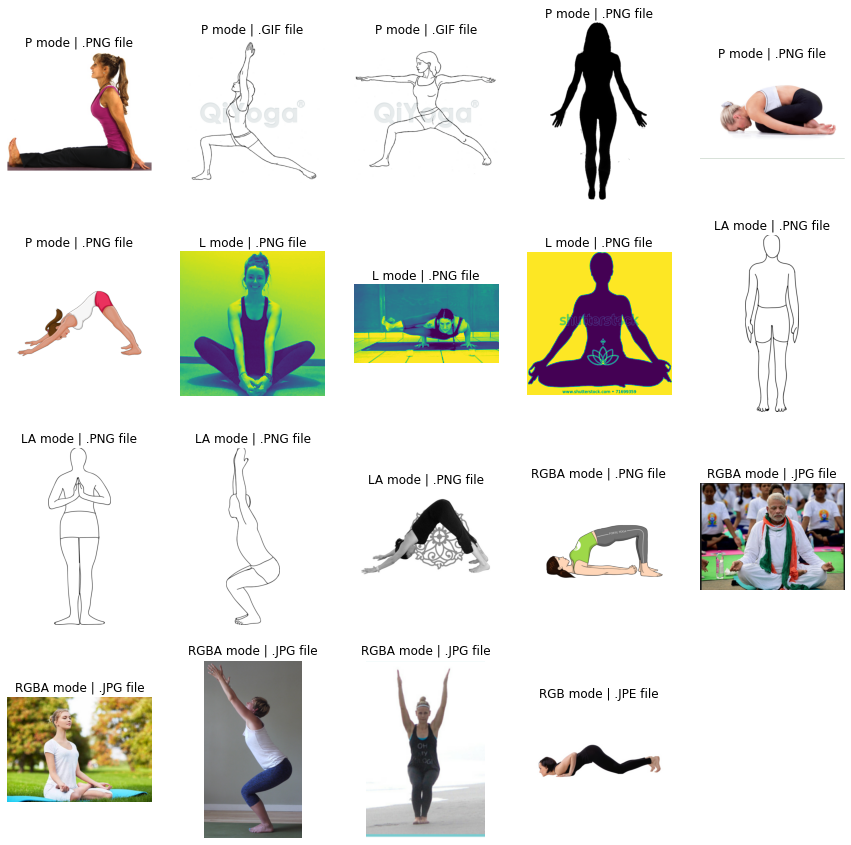

In [25]:
# visualize the images

title_list = []
title_list.append("P mode | .PNG file")
title_list.append("P mode | .GIF file")
title_list.append("P mode | .GIF file")
title_list.append("P mode | .PNG file")
title_list.append("P mode | .PNG file")
title_list.append("P mode | .PNG file")

title_list.append("L mode | .PNG file")
title_list.append("L mode | .PNG file")
title_list.append("L mode | .PNG file")

title_list.append("LA mode | .PNG file")
title_list.append("LA mode | .PNG file")
title_list.append("LA mode | .PNG file")
title_list.append("LA mode | .PNG file")

title_list.append("RGBA mode | .PNG file")
title_list.append("RGBA mode | .JPG file")
title_list.append("RGBA mode | .JPG file")
title_list.append("RGBA mode | .JPG file")
title_list.append("RGBA mode | .JPG file")

title_list.append("RGB mode | .JPE file")

fig = plt.figure(figsize = (15, 15))
rows = 4
columns = 5
i = 1

for path_img in sample_list:
    fig.add_subplot(rows, columns, i)
    plt.imshow(plt.imread(path_img))
    plt.axis('off')
    plt.title(title_list[i-1])
    i = i+1

In [26]:
# create two new folders: 'sample_data' and 'sample_data_backup'
# copy selected images to new folders

!mkdir -p ./yoga_data/sample_data

path = data_path

for ig in sample_list:
    sd_path = path.replace('dataset', 'sample_data') + '/' + ig.rpartition('/')[2]
    shutil.copy(ig, sd_path)

shutil.copytree("./yoga_data/sample_data", "./yoga_data/sample_data_backup")


'./yoga_data/sample_data_backup'

In [38]:
#!ls /content/yoga_data/sample_data
os.listdir("./yoga_data/sample_data")

['31. childspose2.png',
 '46. main-qimg-44e71ec1e2e5f3062e2760538138e986.jpg',
 '3. downward-facing-dog-pose-567x567.png',
 'File36.gif',
 'File62.gif',
 '47. mountain-pose-women-silhouette.png',
 '50. blog-14-size.png',
 '51. 300px-viparita_namaskar_tadasana.png',
 '32. 300px-tadasana.png',
 '81. baddha-konasana-1024x1024.png',
 '5. dandasana-seated-staff-pose.png',
 '35. 200px-utkatasana.png',
 'File34.png',
 '10. ashtanga-namaskara.jpe',
 '24. chairpose2.jpg',
 '39. main-qimg-6af98ebfd563e35051a076689525784b.jpg',
 '43. chair+pose.jpg',
 '7. isolated-silhouette-woman-meditation-lotus-450w-71699359.jpg',
 '321.jpeg']

In [39]:
len(os.listdir("./yoga_data/sample_data"))

19

In [28]:
# add images path to a list

img_list = []

for path_img in os.listdir("./yoga_data/sample_data"):
    img_list.append(os.path.join("./yoga_data/sample_data", path_img))
    
print(f"Thre are {len(img_list)} sample images")

Thre are 19 sample images


In [ ]:
### ---------------------------------------------------------------------------------------------------------------------

In [37]:
# RUN THIS CELL ONLY IF NEEDED !!!

# delete images within 'sample_data' directory
if os.path.exists("./yoga_data/sample_data"):
    shutil.rmtree("./yoga_data/sample_data") #remove non-empty directory
else:
    print("No files found in the directory")

# and copy images from 'sample_data_backup' into 'sample_data' directory
shutil.copytree("./yoga_data/sample_data_backup", "./yoga_data/sample_data")

'./yoga_data/sample_data'

In [ ]:
### ---------------------------------------------------------------------------------------------------------------------

#### 2.2.4. <a name="2.2.4">Define function for converting images mode to RGB mode</a>

##### CONVERSION  METHODS USED: 
*   1) convert L to RGB mode
*   2) convert LA to RGBA mode, then from RGBA to P mode using Image.quantize, and, finally, convert to RGB mode. *Insigt from:* **stackoverflow** [Python PIL remove every alpha channel completely](https://stackoverflow.com/questions/56815743/python-pil-remove-every-alpha-channel-completely)
*   3) convert from P to RGB mode

Note: requires Pillow 9.2.0

In [32]:
!pip show Pillow

Name: Pillow
Version: 9.2.0
Summary: Python Imaging Library (Fork)
Home-page: https://python-pillow.org
Author: Alex Clark (PIL Fork Author)
Author-email: aclark@python-pillow.org
License: HPND
Location: /home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages
Requires: 
Required-by: bokeh, imageio, matplotlib, scikit-image


In [40]:
# define all methods used for converting image mode to 'RGB' mode

def img2mask(item):
    return(item, item, item, 255)


def conv2rgb(img_path):
    """
    convert images mode to 'RGB' mode
    args:
    a PIL.Image object
    """

    img = Image.open(img_path, mode = 'r')
    print("image Loaded")
    temp = img.copy()
    trsy = False

    # filter 'L' images and convert from 'L' to 'RGB' mode
    if temp.mode == 'L':
        
        print(f"converting {img_path} from 'L' to 'RGB' mode")

        # convert to 'RGB'
        temp = temp.convert('RGB')
        
    # filter 'LA' images and convert from 'LA' to 'RGBA' mode
    if temp.mode == 'LA':
        
        print(f"converting {img_path} from 'LA' to 'RGBA' mode")
        
        # convert to 'RGBA'
        t = img.split()
        
        # create an (white) image object with 'RGBA' mode
        Lyr2 = Image.new(mode='RGBA', size=img.size, color=(255, 255, 255))
        
        temp = Image.composite(t[0], Lyr2, t[1])

    # filter 'RGBA' images and convert from 'RGBA' mode to 'RGB' mode
    if temp.mode == 'RGBA':

        print(f"converting {img_path} from 'RGBA' to 'RGB' mode")

        # convert from 'RGBA' to 'P'
        temp = temp.quantize(colors = 256)
        
        # take away warning for transparency expressed in bytes
        if temp.mode == 'P' and 'transparency' in temp.info.keys():
            if temp.info.get('transparency') != None:
                print("'P' mode image with transparency!")
                trsy = True
                temp.apply_transparency()
                print("transparency taken away!")

        # convert from 'P' to 'RGB'
        temp = temp.convert('RGB')
        
    # filter 'P' images and convert from 'P' to 'RGB' mode. Converting P to RGB (!)
    if temp.mode == 'P':
        
        print(f"converting {img_path} from 'P' to 'RGB' mode")

        # take away warning for transparency expressed in bytes
        if 'transparency' in temp.info.keys():
            if temp.info.get('transparency') != None:
                print("'P' mode image with transparency!")
                trsy = True
                temp.apply_transparency()
                print("transparency taken away!")
                
        temp2 = Image.new(mode='RGBA', size=temp.size, color=(255, 255, 255, 0))

        datas = list(temp.getdata())

        newData = []

        # create a mask
        for item in datas:
            newData.append(img2mask(item))

        # 1) create a RGBA mode mask image
        temp2.putdata(newData)

        # 2) white image
        temp3 = Image.new(mode='RGB', size=temp.size, color=(255, 255, 255))

        # 3) original image channel
        t = img.split()

        # Final image
        temp = Image.composite(t[0], temp3, temp2)

    img.close()
    os.remove(img_path)

    nimg_path = img_path.rpartition('.')[0] + '.jpg'
    temp.save(nimg_path, format='JPEG')
    print(f"file saved as: {nimg_path}\n")

    return (nimg_path, trsy)


In [41]:
## test the convertion method in the sample images (convert all sample images to RGB mode)

modified_images = []

i = 0
j = 0
for img_path in img_list:
    print(img_path)
    tst = conv2rgb(img_path)
    modified_images.append(tst[0])
    if tst[1] == True:
        j += 1
    i += 1
    
print(f"{i} images in total!")
print(f"{j} 'P' images with transparency!")

./yoga_data/sample_data/31. childspose2.png
image Loaded
converting ./yoga_data/sample_data/31. childspose2.png from 'P' to 'RGB' mode
'P' mode image with transparency!
transparency taken away!
file saved as: ./yoga_data/sample_data/31. childspose2.jpg

./yoga_data/sample_data/46. main-qimg-44e71ec1e2e5f3062e2760538138e986.jpg
image Loaded
converting ./yoga_data/sample_data/46. main-qimg-44e71ec1e2e5f3062e2760538138e986.jpg from 'RGBA' to 'RGB' mode
file saved as: ./yoga_data/sample_data/46. main-qimg-44e71ec1e2e5f3062e2760538138e986.jpg

./yoga_data/sample_data/3. downward-facing-dog-pose-567x567.png
image Loaded
converting ./yoga_data/sample_data/3. downward-facing-dog-pose-567x567.png from 'P' to 'RGB' mode
'P' mode image with transparency!
transparency taken away!
file saved as: ./yoga_data/sample_data/3. downward-facing-dog-pose-567x567.jpg

./yoga_data/sample_data/File36.gif
image Loaded
converting ./yoga_data/sample_data/File36.gif from 'P' to 'RGB' mode
file saved as: ./yoga_da

In [42]:
# check if images mode are RGB

for sn_path in modified_images:
#for sn_path in img_list:

    f_img = Image.open(sn_path, mode = 'r')

    h,*c = f_img.getbands() #bands: 'R' 'G' 'B' 'A' 'P' 'L' ecc

    if len(c) == 0:
      print(f"{h} , {c}\t|\t{sn_path}")
    elif len(c) == 1:
      print(f"{h} , {c}\t|\t{sn_path}")
    elif len(c) == 2:
      print(f"{h} , {c}\t|\t{sn_path}")
    else:
      print(f"{h} , {c}\t|\t{sn_path}")
        
    f_img.close()

R , ['G', 'B']	|	./yoga_data/sample_data/31. childspose2.jpg
R , ['G', 'B']	|	./yoga_data/sample_data/46. main-qimg-44e71ec1e2e5f3062e2760538138e986.jpg
R , ['G', 'B']	|	./yoga_data/sample_data/3. downward-facing-dog-pose-567x567.jpg
R , ['G', 'B']	|	./yoga_data/sample_data/File36.jpg
R , ['G', 'B']	|	./yoga_data/sample_data/File62.jpg
R , ['G', 'B']	|	./yoga_data/sample_data/47. mountain-pose-women-silhouette.jpg
R , ['G', 'B']	|	./yoga_data/sample_data/50. blog-14-size.jpg
R , ['G', 'B']	|	./yoga_data/sample_data/51. 300px-viparita_namaskar_tadasana.jpg
R , ['G', 'B']	|	./yoga_data/sample_data/32. 300px-tadasana.jpg
R , ['G', 'B']	|	./yoga_data/sample_data/81. baddha-konasana-1024x1024.jpg
R , ['G', 'B']	|	./yoga_data/sample_data/5. dandasana-seated-staff-pose.jpg
R , ['G', 'B']	|	./yoga_data/sample_data/35. 200px-utkatasana.jpg
R , ['G', 'B']	|	./yoga_data/sample_data/File34.jpg
R , ['G', 'B']	|	./yoga_data/sample_data/10. ashtanga-namaskara.jpg
R , ['G', 'B']	|	./yoga_data/sample_d

In [43]:
len(os.listdir("./yoga_data/sample_data"))

19

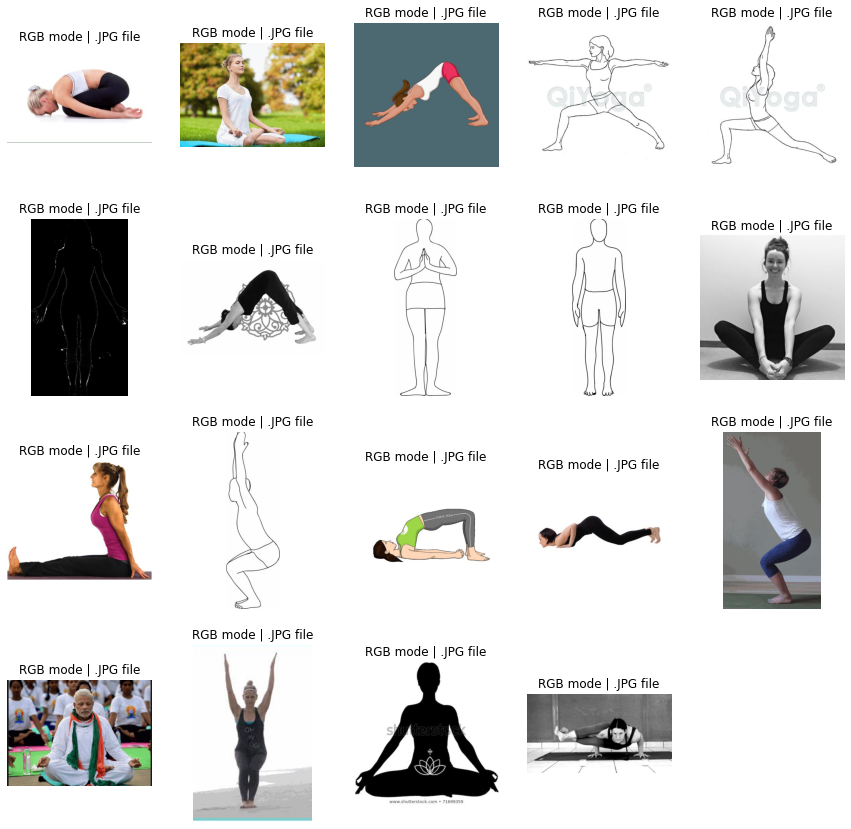

In [44]:
# visualize final images

title_list = []
for i in range(0, len(img_list)):
    title_list.append("RGB mode | .JPG file")

fig = plt.figure(figsize = (15, 15))
rows = 4
columns = 5
i = 1

for path_img in modified_images:
    path_img = path_img.rpartition('.')[0] + '.jpg'
    fig.add_subplot(rows, columns, i)
    plt.imshow(plt.imread(path_img))
    plt.title(title_list[i-1])
    plt.axis('off')
    i = i+1

#### 2.2.5. <a name="2.2.5">Preprocess the full dataset</a>

In [45]:
## it's good practice to make a backup of the dataset before modifying it's content

root = data_path

shutil.copytree(root, "./yoga_data/backup/dataset")

'./yoga_data/backup/dataset'

In [46]:
## convert all images to RGB mode

i = 0
j = 0
root = data_path

for (r, d, f) in os.walk(root, topdown=True):
    for file in f:
        path = os.path.join(r, file)
        tst = conv2rgb(path)
        if tst[1] == True:
            j += 1
        i += 1
    
print(f"{i} images in total!")
print(f"There were {j} 'P' images with transparency expressed in byttes")

image Loaded
file saved as: ./yoga_data/dataset/marjaryasana/55-0.jpg

image Loaded
file saved as: ./yoga_data/dataset/marjaryasana/90-2.jpg

image Loaded
file saved as: ./yoga_data/dataset/marjaryasana/31-0.jpg

image Loaded
file saved as: ./yoga_data/dataset/marjaryasana/77-0.jpg

image Loaded
file saved as: ./yoga_data/dataset/marjaryasana/9-0.jpg

image Loaded
file saved as: ./yoga_data/dataset/marjaryasana/68-0.jpg

image Loaded
file saved as: ./yoga_data/dataset/marjaryasana/0-0.jpg

image Loaded
file saved as: ./yoga_data/dataset/marjaryasana/30-0.jpg

image Loaded
file saved as: ./yoga_data/dataset/marjaryasana/12-0.jpg

image Loaded
file saved as: ./yoga_data/dataset/marjaryasana/3-0.jpg

image Loaded
file saved as: ./yoga_data/dataset/marjaryasana/93-0.jpg

image Loaded
file saved as: ./yoga_data/dataset/marjaryasana/43-1.jpg

image Loaded
file saved as: ./yoga_data/dataset/marjaryasana/83-1.jpg

image Loaded
file saved as: ./yoga_data/dataset/marjaryasana/13-0.jpg

image Loa

In [8]:
## verify files extension GIF, JPEG, PNG, etc
## and file format

root = data_path
t = fileeimg(root)

print(f"{len(t[0])} file extension(s) found: ")
print(t[0])
print('\n')
print(f"{len(t[1])} file format(s) found: ")
print(t[1])
print('\n')
print(f"{len(t[2])} image mode(s) found: ")
print(t[2])

extension: jpg
mode: RGB
format: JPEG


In [8]:
## check for image integrity and remove invalid files
def check_data_integrity(root):
    f_count=0
    invalid_files = []

    for (r, d, f) in os.walk(root, topdown=True):
        for file in f:
            path = os.path.join(r, file)
            f_img = Image.open(path)
            try:
                f_img.load()
            except Exception as e:
                invalid_files.append(file)
                os.remove(path)
            f_img.close()
    print(f"Number of Invalid Files: {len(invalid_files)}")

## call check_data_integrity
check_data_integrity("./yoga_data/dataset")
#check_data_integrity("./yoga_data/backup/dataset")

Number of Invalid Files: 0


#### 2.2.6.<a name="2.2.6">Compress output data</a>

In [ ]:
# compress full dataset into RGB-only-yoga-pose-IC-dataset.zip file
shutil.make_archive("./RGB-only-yoga-pose-IC-dataset", 'zip', "./yoga_data/dataset")

## 3. <a name="3">Clean up</a>
(<a href="#0">Go to top</a>)

In [ ]:
# optional: delete local copy of data
if os.path.exists("./yoga_data/dataset"):
    shutil.rmtree("./yoga_data/dataset" #remove non-empty directory {shutil}
    #os.rmdir("./yoga_data/dataset") #remove empty directory
else:
    print("Files does not exist")

In [ ]:
# optional: delete backup data (you can keep only the zip file)
if os.path.exists("./yoga_data/backup/dataset"):
    shutil.rmtree("./yoga_data/backup/dataset") #remove non-empty directory {shutil}
    #os.rmdir("./yoga_data/backup/dataset") #remove empty directory
else:
    print("Files does not exist")

In [ ]:
#os.remove("./yoga-pose-image-classification-dataset.zip") # delete original dataset zip file
os.remove("./kaggle.json") # delete file with kaggle credentials

In [ ]:
#shutil.rmtree("./yoga_data/sample_data")
#shutil.rmtree("./yoga_data/sample_data_backup")